使い方
- データのパスを指定したのち、上から実行してください

##Prepare

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

Data load

In [ ]:
base_path = "/content/drive/My Drive/LAC/data/"
train_df = pd.read_csv(base_path+"cv_fraudTrain_oh.csv")
test_df = pd.read_csv(base_path+"cv_fraudTest_oh.csv")

##Preprocess/ Feature Engineering

特徴生成や前処理のメソッド

In [ ]:
#詐欺しかしないユーザを除去
def remove_fraud_only_user(train_df):
    train_id = train_df['cc_num'].unique()
    for id_val in train_id:
        tmp_df = train_df[train_df['cc_num'] == id_val]
        fraud_sum = sum(tmp_df['is_fraud'])
        if(fraud_sum== tmp_df.shape[0]):
            train_df = train_df[train_df['cc_num'] != id_val]
    train_id = train_df['cc_num'].unique()
    return train_df, train_id

In [ ]:
#訓練データにないユーザーを削除
def remove_test_only_user(test_df, train_id):
    test_id = test_df['cc_num'].unique()
    for id_val in test_id:
        if(id_val not in train_id):
            test_df = test_df[test_df['cc_num'] != id_val]
    test_id = test_df['cc_num'].unique()
    return test_df, test_id

In [ ]:
#ルールベースの特徴生成方法の1つ
#20:00~06:00の間にフラッグを立てる
def raise_fraud_time_flag(df):
    df["fraud_time"] = 0
    fraud_time_list = [20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6]

    for ft in fraud_time_list:
        column_name = "hour_"+str(ft)
        df.loc[df[column_name] == 1,"fraud_time"] = 1

    return df

In [ ]:
amt_means = []
lat_means = []
long_means = []
amt_stds = [] #このstdはstandard deviationのstd
lat_stds = []
long_stds = []

#IDごとに標準化
def standardization_by_id(df, id, test_flag=0):
    global amt_means, amt_stds, lat_means, lat_stds, long_means, long_stds

    #カラム追加
    df["amt_std"] = 0 #このstdはstandardizationのstd
    df["merch_lat_std"] = 0
    df["merch_long_std"] = 0

    for i, cc_num in enumerate(id):
        #一人分(single person)のデータを取得
        sp_df = df[df["cc_num"] == cc_num].copy()
        
        #正常データ取得
        norm = sp_df[sp_df["is_fraud"]==0]

        #trainデータが入ってきたときに、平均と標準偏差を計算し、格納しておく
        #testデータを標準化する場合、trainデータから得られた平均と標準偏差を利用する
        if test_flag == 0:
            #計算
            amt_mean = np.mean(norm.amt.values)
            amt_std = np.std(norm.amt.values)
            lat_mean = np.mean(norm.merch_lat.values)
            lat_std = np.std(norm.merch_lat.values)
            long_mean = np.mean(norm.merch_long.values)
            long_std = np.std(norm.merch_long.values)
            #格納
            amt_means.append(amt_mean)
            amt_stds.append(amt_std)
            lat_means.append(lat_mean)
            lat_stds.append(lat_std)
            long_means.append(long_mean)
            long_stds.append(long_std)

        #正常データを標準化
        sp_df.loc[sp_df["is_fraud"]==0,"amt_std"] = (norm.amt - amt_means[i])/ amt_stds[i]
        sp_df.loc[sp_df["is_fraud"]==0,"merch_lat_std"] = (norm.merch_lat - lat_means[i]) / lat_stds[i]
        sp_df.loc[sp_df["is_fraud"]==0,"merch_long_std"] = (norm.merch_long - long_means[i]) / long_stds[i]

        #異常データが存在する場合の処理
        if (sp_df["is_fraud"] == 1).any():
            #異常データ取得
            anom =  sp_df[sp_df["is_fraud"]==1]
            #異常データを標準化
            sp_df.loc[sp_df["is_fraud"]==1,"amt_std"] = (anom.amt - amt_means[i]) / amt_stds[i]
            sp_df.loc[sp_df["is_fraud"]==1,"merch_lat_std"] = (anom.merch_lat - lat_means[i]) / lat_stds[i]
            sp_df.loc[sp_df["is_fraud"]==1,"merch_long_std"] = (anom.merch_long - long_means[i]) / long_stds[i]
    
        #元のdfに格納し直す
        df.loc[df["cc_num"] == cc_num,"amt_std"] = sp_df["amt_std"]
        df.loc[df["cc_num"] == cc_num,"merch_lat_std"] = sp_df["merch_lat_std"]
        df.loc[df["cc_num"] == cc_num,"merch_long_std"] = sp_df["merch_long_std"]
    
    return df

In [ ]:
#自乗
def square(df):
    
    df["amt_square"] = df["amt"]**2
    df["long_square"] = df["merch_long"]**2
    df["lat_square"] = df["merch_lat"]**2
    df["dis_square"] = df["distance"]**2
    
    return df

In [ ]:
#log
def log(df):
    
    #merch_lat/ longはマイナスの値を取ることがあるためlogを計算できない
    df["amt_log"] = np.log(df["amt"])
    df["dis_log"] = np.log(df["distance"])

    return df

In [ ]:
amt_bins = []
lat_bins = []
long_bins = []
dis_bins = []

#ビニング
def binning(df, test_flag=0):
    global amt_bins, lat_bins, long_bins, dis_bins

    #trainデータの処理
    if test_flag == 0:
        # df["xxx_bin"] : binに分けたカラムを生成する
        # xxx_bins : ビニングする際の閾値を取得
        df["amt_bin"], amt_bins = pd.qcut(df["amt"],10,labels=[i for i in range(10)],retbins=True)
        df["lat_bin"], lat_bins = pd.qcut(df["merch_lat"],10,labels=[i for i in range(10)],retbins=True)
        df["long_bin"], long_bins = pd.qcut(df["merch_long"],10,labels=[i for i in range(10)],retbins=True)
        df["dis_bin"], dis_bins = pd.qcut(df["distance"],10,labels=[i for i in range(10)],retbins=True)

        #ビニングの上限/下限の閾値をtestデータの処理時に上回ったり、下回ってしまうとNaNになる
        #なので上限/下限を変更している
        amt_bins[0] = -1.0
        lat_bins[0] = -10000.0
        long_bins[0] = -10000.0
        dis_bins[0] = -1.0
        amt_bins[10] = 1000000
        lat_bins[10] = 1000000
        long_bins[10] = 1000000
        dis_bins[10] = 1000000

    #testデータの処理
    else:
        df["amt_bin"] = pd.cut(df["amt"],amt_bins,labels=[i for i in range(10)])
        df["lat_bin"] = pd.cut(df["merch_lat"],lat_bins,labels=[i for i in range(10)])
        df["long_bin"] = pd.cut(df["merch_long"],long_bins,labels=[i for i in range(10)])
        df["dis_bin"] = pd.cut(df["distance"],dis_bins,labels=[i for i in range(10)])
        
    return df

In [ ]:
def preprocess(train, test):

    #ID選定及びID取得
    train, train_id = remove_fraud_only_user(train)
    test, test_id = remove_test_only_user(test, train_id)

    #genderのonehot化
    train = pd.concat([train,pd.get_dummies(train["gender"])], axis=1).copy()
    test = pd.concat([test,pd.get_dummies(test["gender"])], axis=1).copy()

    return train, test, train_id, test_id

In [ ]:
def feature_generation(train, test, train_id, test_id):
    #20:00~06:00のフラッグ
    train, test = raise_fraud_time_flag(train), raise_fraud_time_flag(test)

    #標準化したカラムを追加
    train, test = standardization_by_id(train, train_id), standardization_by_id(test, test_id)

    #特徴変換
    ##自乗
    train, test = square(train), square(test)
    ##log
    train, test = log(train), log(test)
    ##ビニング
    train, test = binning(train, 0), binning(test, 1)

    return train, test

前処理

In [ ]:
train_df_pp, test_df_pp, train_id, test_id = preprocess(train_df, test_df)

特徴生成

In [ ]:
train_df_fg, test_df_fg = feature_generation(train_df_pp, test_df_pp, train_id, test_id)

データ数確認

In [ ]:
#trainデータの正常:異常
len(train_df_fg[train_df_fg["is_fraud"] == 0]), len(train_df_fg[train_df_fg["is_fraud"] == 1])

(1289169, 6765)

In [ ]:
#testデータの正常:異常
len(test_df_fg[test_df_fg["is_fraud"] == 0]), len(test_df_fg[test_df_fg["is_fraud"] == 1])

(553574, 1982)

##Train

###全データ

In [ ]:
#無駄なカラムを落としつつndarrayの学習/テストデータへ変換
X_train, y_train = train_df_fg.drop(['Unnamed: 0',"cc_num",'is_fraud', "merchant", "gender"], axis=1).values, train_df_fg['is_fraud'].values
X_test, y_test = test_df_fg.drop(['Unnamed: 0', "cc_num",'is_fraud', "merchant", "gender"], axis=1).values, test_df_fg['is_fraud'].values

In [ ]:
#特徴生成によりNaNが混入していないか確認
np.isnan(X_train).any(),np.isnan(X_test).any()

(False, False)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1295934, 111), (1295934,), (555556, 111), (555556,))

学習

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#predictを使うとROC曲線が書けないため、以下のように予測している
clf_pred = clf.predict_proba(X_test)
pred_proba = []
for pred in clf_pred:
    if pred[0] > pred[1]:
        pred_proba.append(1 - pred[0])
    else:
        pred_proba.append(pred[1])
pred_proba = np.array(pred_proba)

In [ ]:
# # 1つ上のコードの代わりに以下のコードを実行することで閾値(threshold)を変化させて分類可能
# # なおこの方法をとる場合はROCを描けなくなるので注意(ROCは1つ上のコードで描く)
# threshold = 0.25
# pred_proba = (clf.predict_proba(X_test)[:,1] >= threshold).astype(int)

結果

In [ ]:
#分類の評価の一覧を表示
print(classification_report(y_test, np.round(pred_proba)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.92      0.65      0.76      1982

    accuracy                           1.00    555556
   macro avg       0.96      0.83      0.88    555556
weighted avg       1.00      1.00      1.00    555556



Text(83.40000000000006, 0.5, 'true')

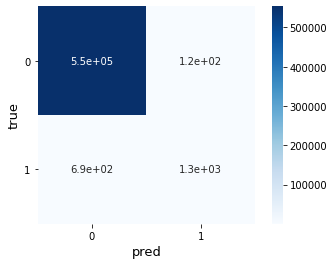

In [ ]:
#混同行列
cm = confusion_matrix(y_test, np.round(pred_proba))
cm = pd.DataFrame(data=cm, index=[0, 1], columns=[0, 1])
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.xlabel("pred", fontsize=13, rotation=0)
plt.ylabel("true", fontsize=13)

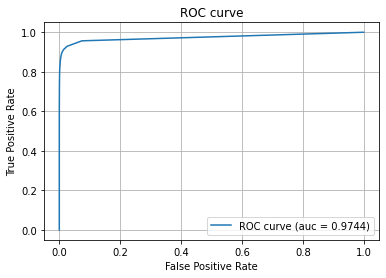

In [ ]:
#ROC曲線

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)

# AUC
auc_score = auc(fpr.astype("float32"), tpr.astype("float32"))

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (auc = %.4f)'%auc_score)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

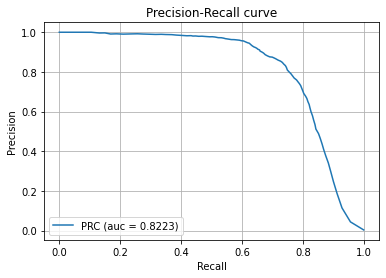

In [ ]:
#PRC
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba)

auc_score = auc(recall.astype("float32"), precision.astype("float32"))

plt.plot(recall, precision, label='PRC (auc = %.4f)'%auc_score)
plt.legend()
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [ ]:
all_fn = train_df_fg.drop(['Unnamed: 0',"cc_num",'is_fraud', "merchant", "gender"], axis=1).columns

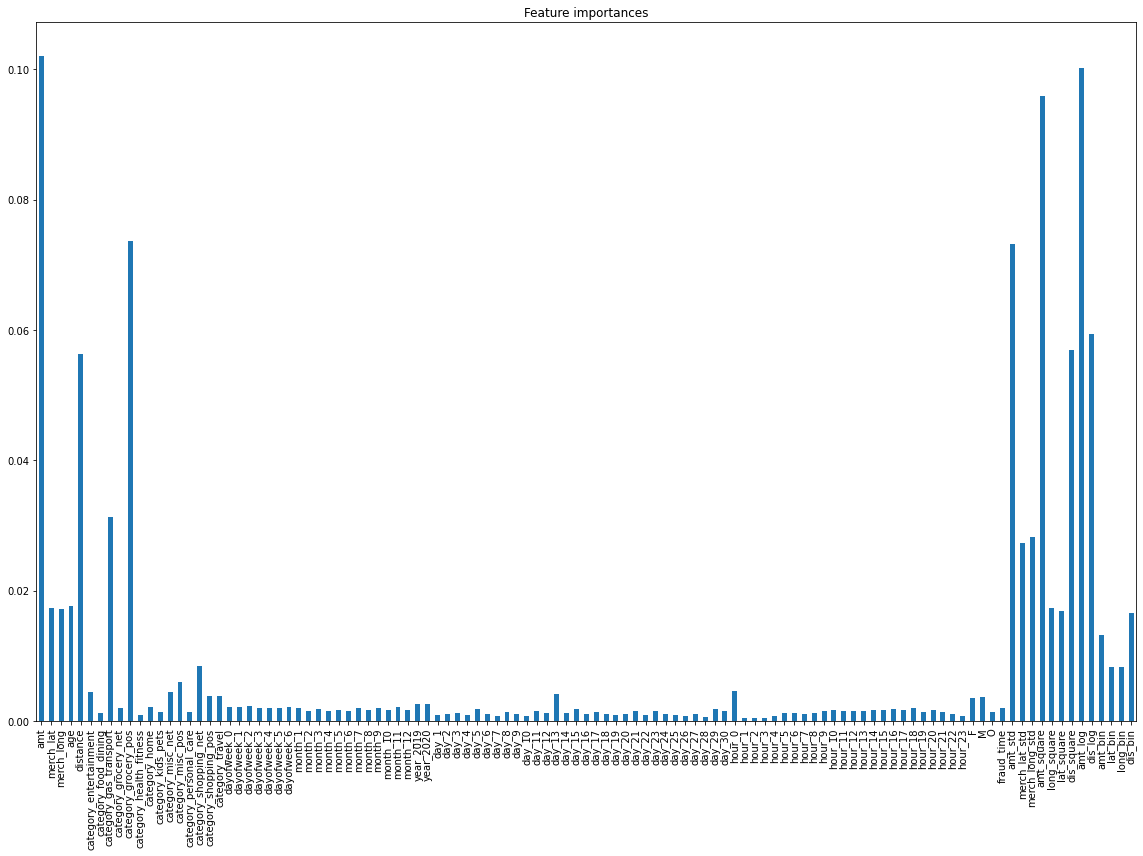

In [ ]:
#FIの可視化
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index=all_fn)

fig, ax = plt.subplots(figsize=(16,12))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
fig.tight_layout()

###特徴選択したデータのみ

XGBを用いて特徴選択

In [ ]:
clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
clf_pred = clf.predict_proba(X_test)
pred_proba = []
for pred in clf_pred:
    if pred[0] > pred[1]:
        pred_proba.append(1 - pred[0])
    else:
        pred_proba.append(pred[1])
pred_proba = np.array(pred_proba)

In [ ]:
#特徴選択の実行
model = SelectFromModel(clf, prefit=True)
X_train_fs = model.transform(X_train)
X_test_fs = model.transform(X_test)

In [ ]:
#特徴選択されたカラムの格納
selected_fn = all_fn[model.get_support()]

特徴選択されたデータを用いて学習

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train_fs, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
clf_pred = clf.predict_proba(X_test_fs)
pred_proba = []
for pred in clf_pred:
    if pred[0] > pred[1]:
        pred_proba.append(1 - pred[0])
    else:
        pred_proba.append(pred[1])
pred_proba = np.array(pred_proba)

結果

In [ ]:
#分類の評価の一覧を表示
print(classification_report(y_test, np.round(pred_proba)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.91      0.67      0.77      1982

    accuracy                           1.00    555556
   macro avg       0.95      0.84      0.89    555556
weighted avg       1.00      1.00      1.00    555556



Text(83.40000000000006, 0.5, 'true')

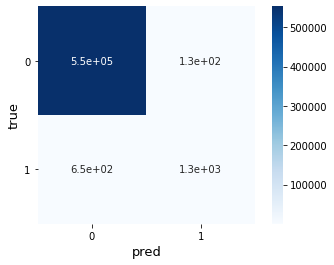

In [ ]:
#混同行列
cm = confusion_matrix(y_test, np.round(pred_proba))
cm = pd.DataFrame(data=cm, index=[0, 1], columns=[0, 1])
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.xlabel("pred", fontsize=13, rotation=0)
plt.ylabel("true", fontsize=13)

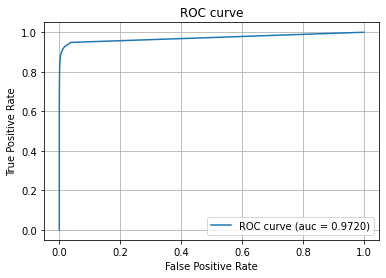

In [ ]:
#ROC曲線

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)

# AUC
auc_score = auc(fpr.astype("float32"), tpr.astype("float32"))

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (auc = %.4f)'%auc_score)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

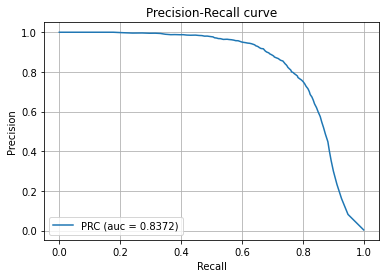

In [ ]:
#PRC
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba)

auc_score = auc(recall.astype("float32"), precision.astype("float32"))

plt.plot(recall, precision, label='PRC (auc = %.4f)'%auc_score)
plt.legend()
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

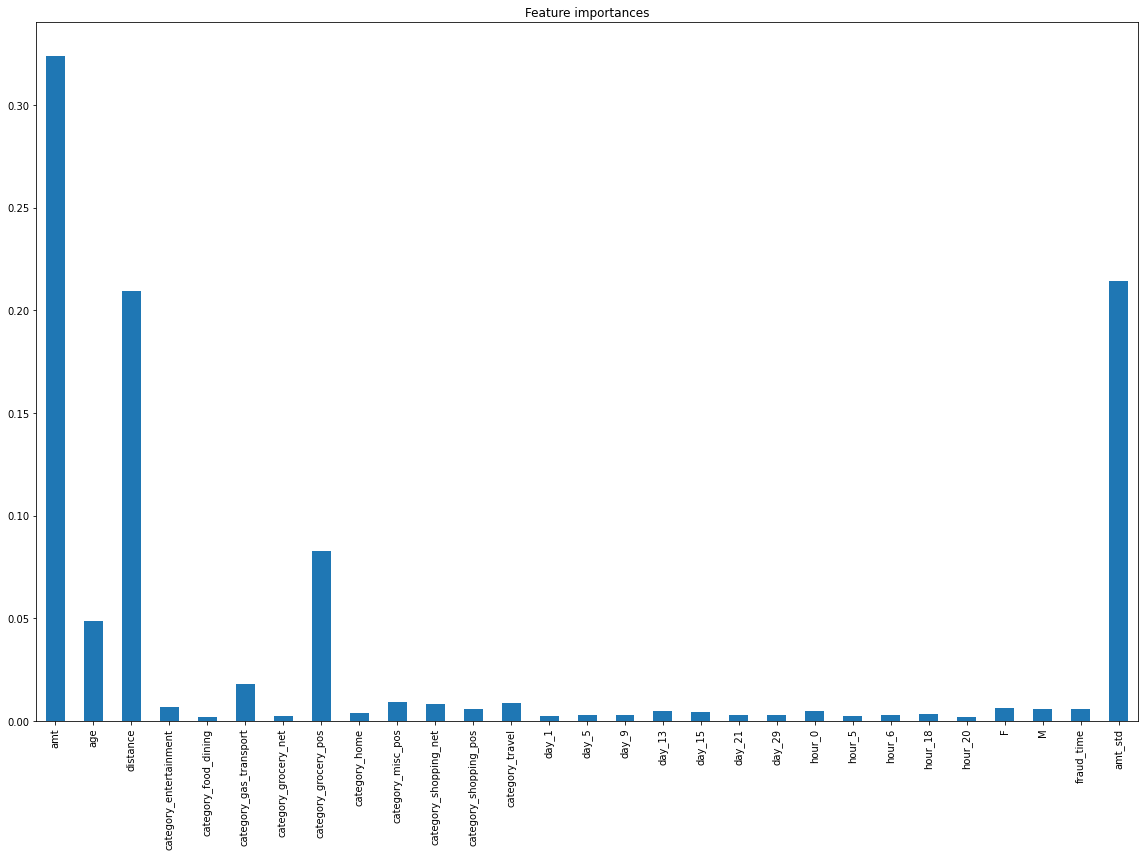

In [ ]:
#FIの可視化
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index=selected_fn)

fig, ax = plt.subplots(figsize=(16,12))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
fig.tight_layout()

###全データ+特徴抽出したデータ

特徴抽出

In [ ]:
pca = PCA(20)
pca.fit(X_train) #testデータをtrainでは使えないためtrainのみfit
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

concat

In [ ]:
X_train_all_pca = np.concatenate([X_train, X_train_pca], axis=1)
X_test_all_pca = np.concatenate([X_test, X_test_pca], axis=1)

In [ ]:
X_train_pca.shape, X_test_pca.shape

((1295934, 20), (555556, 20))

In [ ]:
X_train_all_pca.shape, X_test_all_pca.shape

((1295934, 131), (555556, 131))

学習

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train_all_pca, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
clf_pred = clf.predict_proba(X_test_all_pca)
pred_proba = []
for pred in clf_pred:
    if pred[0] > pred[1]:
        pred_proba.append(1 - pred[0])
    else:
        pred_proba.append(pred[1])
pred_proba = np.array(pred_proba)

結果

In [ ]:
#分類の評価の一覧を表示
print(classification_report(y_test, np.round(pred_proba)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.91      0.65      0.76      1982

    accuracy                           1.00    555556
   macro avg       0.96      0.83      0.88    555556
weighted avg       1.00      1.00      1.00    555556



Text(83.40000000000006, 0.5, 'true')

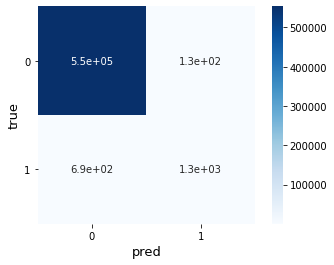

In [ ]:
#混同行列
cm = confusion_matrix(y_test, np.round(pred_proba))
cm = pd.DataFrame(data=cm, index=[0, 1], columns=[0, 1])
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.xlabel("pred", fontsize=13, rotation=0)
plt.ylabel("true", fontsize=13)

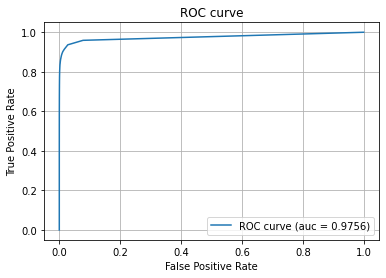

In [ ]:
#ROC曲線

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)

# AUC
auc_score = auc(fpr.astype("float32"), tpr.astype("float32"))

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (auc = %.4f)'%auc_score)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

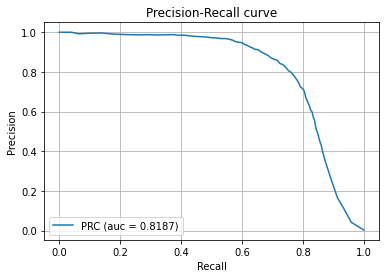

In [ ]:
#PRC
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba)

auc_score = auc(recall.astype("float32"), precision.astype("float32"))

plt.plot(recall, precision, label='PRC (auc = %.4f)'%auc_score)
plt.legend()
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [ ]:
all_fn = list(all_fn)
pca_fn = ["pca"+str(i) for i in range(20)]
all_pca_fn = all_fn + pca_fn

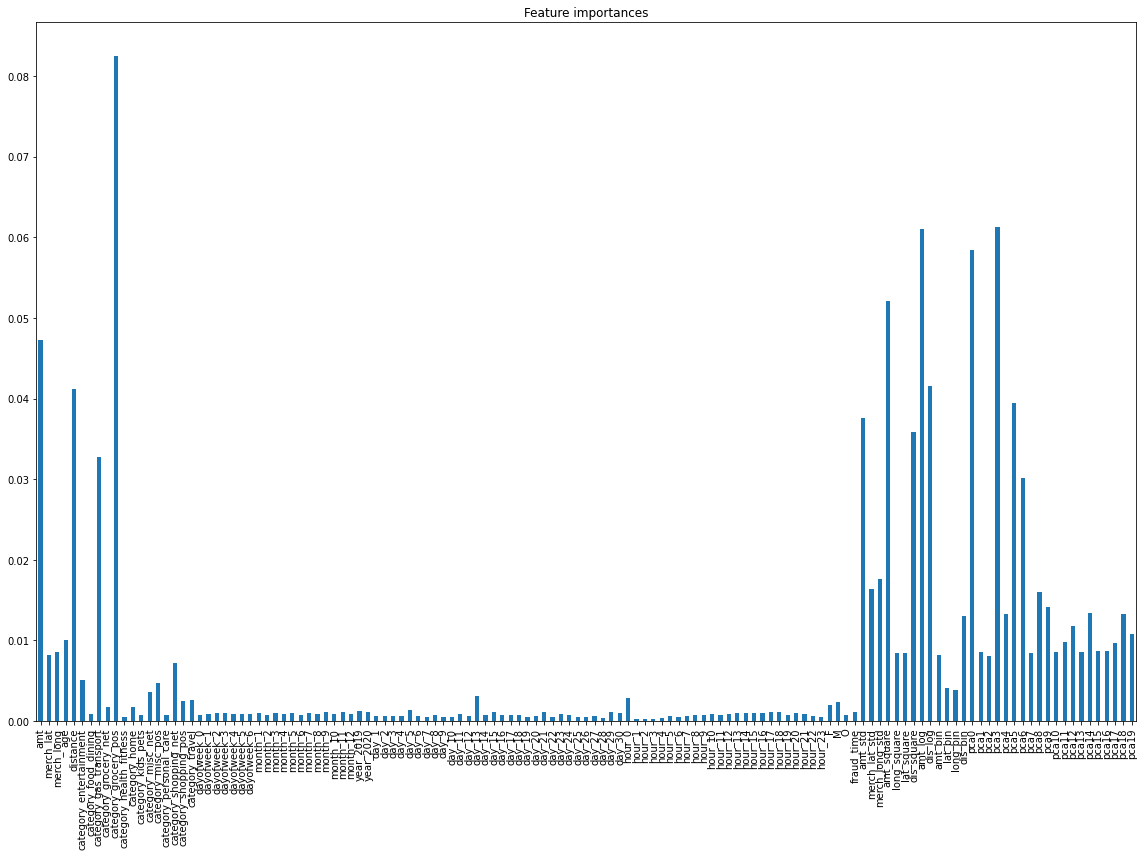

In [ ]:
#FIの可視化
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index=all_pca_fn)

fig, ax = plt.subplots(figsize=(16,12))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
fig.tight_layout()

###特徴選択したデータ+特徴抽出したデータ

concat

In [ ]:
X_train_fs_pca = np.concatenate([X_train_fs, X_train_pca], axis=1)
X_test_fs_pca = np.concatenate([X_test_fs, X_test_pca], axis=1)

学習

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train_fs_pca, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
clf_pred = clf.predict_proba(X_test_fs_pca)
pred_proba = []
for pred in clf_pred:
    if pred[0] > pred[1]:
        pred_proba.append(1 - pred[0])
    else:
        pred_proba.append(pred[1])
pred_proba = np.array(pred_proba)

結果

In [ ]:
#分類の評価の一覧を表示
print(classification_report(y_test, np.round(pred_proba)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.90      0.67      0.77      1982

    accuracy                           1.00    555556
   macro avg       0.95      0.83      0.88    555556
weighted avg       1.00      1.00      1.00    555556



Text(83.40000000000006, 0.5, 'true')

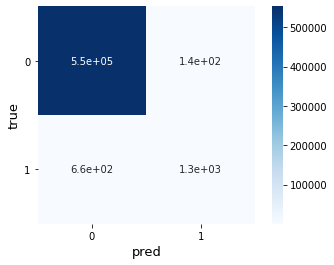

In [ ]:
#混同行列
cm = confusion_matrix(y_test, np.round(pred_proba))
cm = pd.DataFrame(data=cm, index=[0, 1], columns=[0, 1])
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.xlabel("pred", fontsize=13, rotation=0)
plt.ylabel("true", fontsize=13)

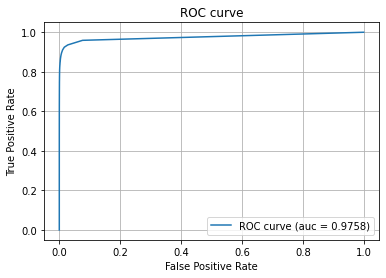

In [ ]:
#ROC曲線

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)

# AUC
auc_score = auc(fpr.astype("float32"), tpr.astype("float32"))

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (auc = %.4f)'%auc_score)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

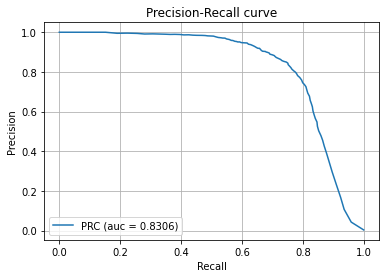

In [ ]:
#PRC
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba)

auc_score = auc(recall.astype("float32"), precision.astype("float32"))

plt.plot(recall, precision, label='PRC (auc = %.4f)'%auc_score)
plt.legend()
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [ ]:
selected_fn = list(selected_fn)

In [ ]:
selected_pca_fn = selected_fn + pca_fn

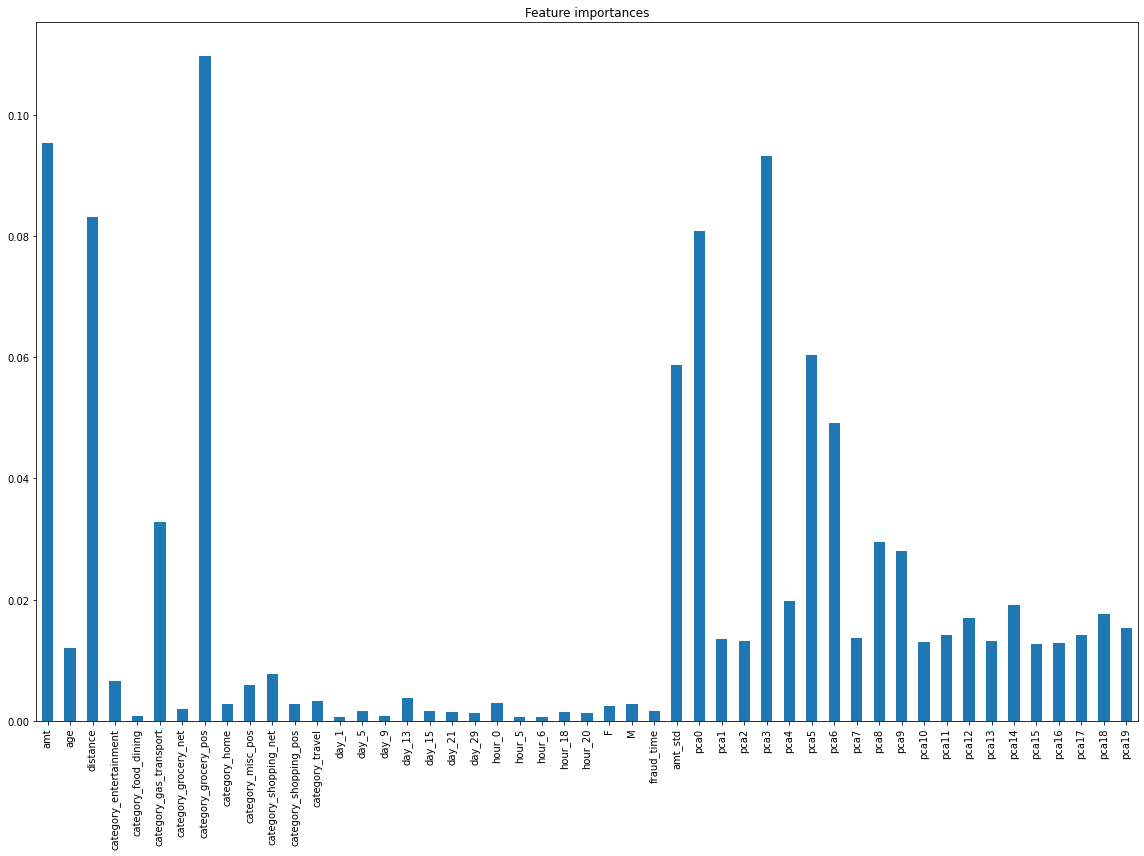

In [ ]:
#FIの可視化
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index=selected_pca_fn)

fig, ax = plt.subplots(figsize=(16,12))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
fig.tight_layout()